In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import display
import torchvision.models as models

import itertools
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
from torch.cuda.amp import autocast

from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.amp import GradScaler, autocast

import optuna
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_squared_error

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
events_df = pd.read_csv('../data/events.csv')
events_df.head()

,X_1,Y_1,Z_1,t_1,X_2,Y_2,Z_2,t_2,X_3,Y_3,...,A_27,A_28,A_29,A_30,A_31,A_32,A_33,A_34,A_35,A_36
0,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,1,-1,-1,1,-1,1,-1,-1,-1,-1
1,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,1,-1,-1,-1,-1,-1,1,1,1,1
2,-25.359,5.885,-6.684,81.032,-37.609,5.885,-6.684,52.578,-37.609,-7.315,...,-1,-1,-1,1,-1,1,-1,-1,-1,-1
3,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-25.359,5.885,-6.684,25.786,-37.609,5.885,-6.684,13.556,-37.609,-7.315,...,-1,-1,1,1,1,1,1,1,1,1


In [13]:
X_events = events_df.drop(
    columns=['theta', 'phi']).values
y_events = events_df[['theta']].values

In [3]:
data = pd.read_csv('../data/expanded_synthetic_dataset.csv')
data.head()

,X_1,Y_1,Z_1,t_1,X_2,Y_2,Z_2,t_2,X_3,Y_3,...,A_27,A_28,A_29,A_30,A_31,A_32,A_33,A_34,A_35,A_36
0,-25.359,5.885,-6.684,78.875263,-37.609,5.885,-6.684,74.805427,-37.609,-7.315,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,-1.000,-1.000,-1.000,-1.000000,-1.000,-1.000,-1.000,-1.000000,-1.000,-1.000,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,-1.000,-1.000,-1.000,-1.000000,-1.000,-1.000,-1.000,-1.000000,-1.000,-1.000,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,-1.000,-1.000,-1.000,-1.000000,-1.000,-1.000,-1.000,-1.000000,-1.000,-1.000,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-1.000,-1.000,-1.000,-1.000000,-1.000,-1.000,-1.000,-1.000000,-1.000,-1.000,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [4]:
X = data.drop(columns=['theta', 'phi']).values
y = data[['theta']].values

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_train_tensor = y_train_tensor.squeeze()
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
y_test_tensor = y_test_tensor.squeeze()

In [ ]:
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True, pin_memory=True
)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 4)
        self.fc2 = nn.Linear(4, 2)
        self.fc3 = nn.Linear(2, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = RegressionModel(X_train.shape[1]).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()
scaler = GradScaler(device)

num_epochs = 10
train_mse = []
train_mae = []

In [ ]:
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, pin_memory=False)

In [ ]:
num_epochs = 3

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    steps = 0

    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", ncols=100, position=0, leave=True) as pbar:
        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            with autocast('cuda'):
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
            scaler.scale(loss).backward()

            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()
            steps += 1

            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

            pbar.update(1)

            if steps % 1000 == 0:
                avg_loss = running_loss / steps
                pbar.set_postfix(avg_loss=avg_loss)

    print(
        f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
    torch.cuda.empty_cache()

Epoch 1/3, Loss: 213.1744: 100%|██████████████▉| 92515/92517 [07:59<00:00, 200.79it/s, avg_loss=218]c:\Users\matsvei\.ai-navigator\conda\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([17, 1])) that is different to the input size (torch.Size([17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/3, Loss: 246.3882: 100%|███████████████| 92517/92517 [07:59<00:00, 192.83it/s, avg_loss=218]


Epoch [1/3], Loss: 218.4501


Epoch 2/3, Loss: 269.6969: 100%|███████████████| 92517/92517 [08:03<00:00, 191.16it/s, avg_loss=218]


Epoch [2/3], Loss: 217.8807


Epoch 3/3, Loss: 253.3199: 100%|███████████████| 92517/92517 [08:30<00:00, 181.14it/s, avg_loss=217]

Epoch [3/3], Loss: 216.9783


In [109]:
torch.cuda.empty_cache()

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X_events, y_events, test_size=0.9, random_state=42)

In [41]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

with tqdm(total=10, desc="Training LightGBM", unit="iteration") as pbar:
    def tqdm_callback(env):
        pbar.update(1)

    clf = lgb.train(params,
                    train_data,
                    valid_sets=[test_data],
                    num_boost_round=10,
                    valid_names=['test'],
                    callbacks=[tqdm_callback])

Training LightGBM:   0%|          | 0/10 [00:00<?, ?iteration/s]c:\Users\matsvei\.ai-navigator\conda\Lib\site-packages\lightgbm\basic.py:357: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")
Training LightGBM: 100%|██████████| 10/10 [00:00<00:00, 370.37iteration/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2865
[LightGBM] [Info] Number of data points in the train set: 521, number of used features: 180
[LightGBM] [Info] Start training from score 0.871281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\matsvei\.ai-navigator\conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 0.11563494126594234
Size of y_test: (4694, 1), Size of y_pred: (4694,)
Size of flattened y_test: (4694,), Size of flattened y_pred: (4694,)


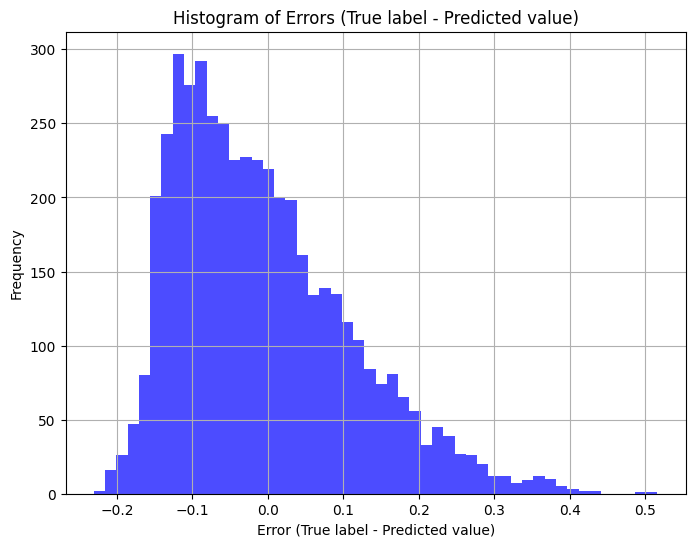

In [42]:
y_pred = clf.predict(X_test, num_iteration=clf.best_iteration)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

print(f"Size of y_test: {y_test.shape}, Size of y_pred: {y_pred.shape}")

y_test_flat = np.ravel(y_test)
y_pred_flat = np.ravel(y_pred)

print(f"Size of flattened y_test: {
      y_test_flat.shape}, Size of flattened y_pred: {y_pred_flat.shape}")

errors = y_test_flat - y_pred_flat

plt.figure(figsize=(8, 6))
plt.hist(errors, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Errors (True label - Predicted value)')
plt.xlabel('Error (True label - Predicted value)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [43]:
X_events = X_events.astype('float32')
y_events = y_events.astype('float32')

c:\Users\matsvei\.ai-navigator\conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 0.11525470027215264
Size of y_test: (5215, 1), Size of y_pred: (5215,)
Size of flattened y_test: (5215,), Size of flattened y_pred: (5215,)


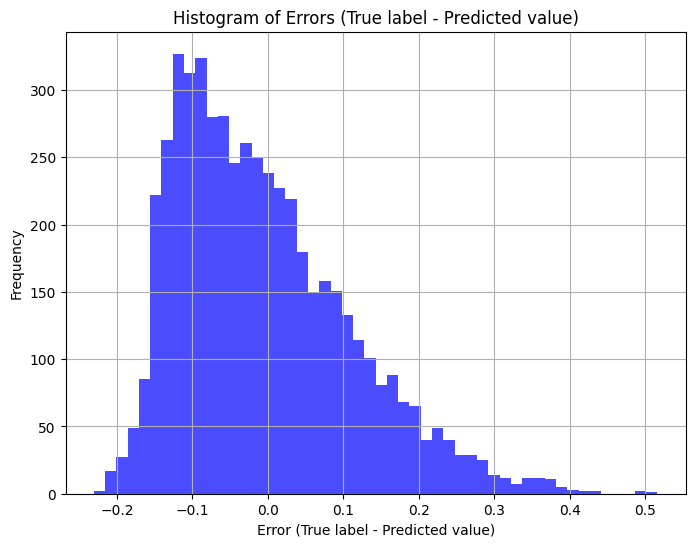

In [44]:
y_pred = clf.predict(X_events, num_iteration=clf.best_iteration)

rmse = mean_squared_error(y_events, y_pred, squared=False)
print(f'RMSE: {rmse}')

print(f"Size of y_test: {y_events .shape}, Size of y_pred: {y_pred.shape}")

y_events_flat = np.ravel(y_events)
y_pred_flat = np.ravel(y_pred)

print(f"Size of flattened y_test: {
      y_events_flat.shape}, Size of flattened y_pred: {y_pred_flat.shape}")

errors = y_events_flat - y_pred_flat

plt.figure(figsize=(8, 6))
plt.hist(errors, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Errors (True label - Predicted value)')
plt.xlabel('Error (True label - Predicted value)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()